In [211]:
import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline
import mpld3
import pandas as pd
import json
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report as report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix as cm

# Loading and Preprocessing Data

In [79]:
# load in data
train_df = pd.read_csv('data/all_train_normed.csv')
test_df = pd.read_csv('data/all_test_normed.csv')

In [88]:
# the neo columns have missing values, fill them with zeros
train_df = train_df.convert_objects(convert_numeric=True)
test_df = test_df.convert_objects(convert_numeric=True)
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

/Users/thomaseffland/.virtualenvs/speech/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app
/Users/thomaseffland/.virtualenvs/speech/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


In [89]:
# create the training and testing X and y
ignore_cols = ['turn', 'person', 'text', 'label']
train_x = train_df.drop(ignore_cols, axis=1).as_matrix()
train_y = train_df['label'].as_matrix()
test_x = test_df.drop(ignore_cols, axis=1).as_matrix()
test_y = test_df['label'].as_matrix()
print (train_x.shape, train_y.shape, test_x.shape, test_y.shape)

((2377, 6545), (2377,), (473, 6545), (473,))


In [202]:
# training baseline
class_counts = train_df['label'].value_counts()
train_base_acc = max(class_counts)/float(sum(class_counts))
print "Training Baseline Accuracy %0.4f" % train_base_acc
# test baseline
class_counts = test_df['label'].value_counts()
print "Class counts: ", class_counts
base_acc = max(class_counts)/float(sum(class_counts))
print "Baseline Accuracy %0.4f" % base_acc
# class labels
class_names = ['Not Deceptive', 'Deceptive'] # 0 is truth, 1 is lie


Training Baseline Accuracy 0.5322
Class counts:  0    266
1    207
Name: label, dtype: int64
Baseline Accuracy 0.5624


# Baseline models

## Helper Functions for running a fair experiment and looking at results

In [319]:
def experiment(clf, param_grid, grid_metric='accuracy',
               train_x=train_x, train_y=train_y, 
               test_x=test_x, test_y=test_y, 
               label_names=class_names, cv=10):
    """Run GridSearchCv on the pipeline `clf` with `cv` number of folds over `grid`
    
    Then refit the best parameters on all of the train data, and analyze the test performance
    
    Performance metrics: accuracy, f1-score for Deceptive, confusion matrix
    
    NOTE: Specify parallel jobs in clf.  Won't do grid search in parallel.
    """
    print "Searching Grid..."
    grid = GridSearchCV(clf, param_grid, grid_metric, cv=cv, verbose=1)
    grid.fit(train_x, train_y)
    print "Fitting best estimator..."
    print "Chosen parameters: \n", grid.best_params_
    print "Best Estimator: \n", grid.best_estimator_
    clf.set_params(**grid.best_params_)
    clf.fit(train_x, train_y)
    print "Evaluating on Test..."
    preds = clf.predict(test_x)
    acc = accuracy_score(test_y, preds)
    p = precision_score(test_y, preds)
    r = recall_score(test_y, preds)
    f1 = f1_score(test_y, preds)
    print "Test Accuracy: %1.4f, Test F1: %1.4f (P:%0.2f R:%0.2f)" % (acc, f1, p, r)
    confusion_matrix = cm(test_y, preds)
    results = {'clf': clf,
               'best_params':grid.best_params_,
               'grid_scores':grid.grid_scores_,
               'acc':acc,
               'f1':f1, 'precision':p, 'recall':r,
               'cm':confusion_matrix}
    return results

def plot_confusion_matrix(cm, label_names=class_names, save_name=None, 
                          title='Normed Confusion matrix', 
                          cmap=plt.cm.Blues, 
                          stats=None):
    """Take confusion matrix, label names and plot a very nice looking confusion matrix
    Args:
        cm: a confustion matrix w/ prediction rows and true columns
        label_names: list of class names for tick labels
        save_name (optional): if provided, save the figure to this location
        title (optional): the desired title
        cmap (optional): the colormap to display cell magnitudes with
        stats (optional): if stats, label class precisions and macro stats
    """
    fig, ax = plt.subplots(figsize=(6,6))
    
    # calc normalized cm
    x, y = np.meshgrid(range(cm.shape[0]), range(cm.shape[1]))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    
    # print nonzero raw counts
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        norm = cm_normalized[x_val, y_val]
        c = "%i" % (cm.astype('int')[x_val, y_val])
        if norm > 0.0:
            color = 'white' if norm > .5 else 'black'
            ax.text(y_val, x_val, c, va='center', ha='center', color=color, fontsize=14)
    
    # actual plot
    im = ax.imshow(cm_normalized, interpolation='nearest', origin='upper', cmap=cmap)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    # set ticks and offset grid
    tick_marks = np.arange(len(label_names))
    tick_marks_offset = np.arange(len(label_names)) - .5
    ax.set_xticks(tick_marks, minor=False)
    ax.set_yticks(tick_marks, minor=False)
    ax.set_xticks(tick_marks_offset, minor=True)
    ax.set_yticks(tick_marks_offset, minor=True)
    ax.grid(which='minor')
    if stats:
        # include micro precisio, recall, and f1
        aug_y_labels = []
        for i in range(len(label_names)):
            aug = ("%s\nP:%0.2f, R:%0.2f, F1:%0.2f" 
                   % (label_names[i],
                      stats['class_precision'][i],
                      stats['class_recall'][i],
                      stats['class_f1'][i],))
            aug_y_labels.append(aug)
    else:
        aug_y_labels = label_names
    ax.set_xticklabels(label_names, horizontalalignment='left')
    ax.set_yticklabels(aug_y_labels)
    
    # other stuff
    plt.tight_layout()
    plt.ylabel('Predicted Labels', fontsize=16)
    if stats:
        # include macro 
        aug_x_label = ("True Labels\n Micro P:%0.2f, R:%0.2f, F1:%0.2f\n Macro P:%0.2f, R:%0.2f, F1:%0.2f" 
                       % (stats['micro_precision'], stats['micro_recall'], stats['micro_f1'],
                          stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))
    else:
        aug_x_label = "True Label"
    plt.xlabel(aug_x_label, fontsize=16)
    plt.title(title, fontsize=18)
    if save_name:
        plt.savefig(save_name+'.pdf')
        
def plot_grid_scores(grid_scores, baseline=base_acc):
    """Take grid scores and plot interactive box and whisker plot with baseline reference"""
    # determine endpoint of baseline
    cv_scores = [s[2] for s in grid_scores] # 2 is cross val scores
    labels = ["\n".join([str(val) for val in s[0].values()]) for s in grid_scores]
    x_label = ", ".join([str(key) for key in grid_scores[0][0].keys()])
    fig, ax = plt.subplots(figsize=(15,6))
    boxes = ax.boxplot(cv_scores)
    ax.hlines([baseline], [0], [len(grid_scores) + 1], linestyles='dashed', label='Baseline Accuracy')
    
    plt.legend(loc='best')
    ax.set_title("Cross Validation Scores")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel(x_label)
    ax.set_xticklabels(labels, fontsize=8)
    plt.show()

In [210]:
random_seed = 42

## Random Forest

In [316]:
from sklearn.ensemble import RandomForestClassifier as RF

rf = RF(verbose=0, n_jobs=-1, random_state=random_seed)
param_grid =dict(n_estimators=[5, 10, 50, 100, 200], 
                 criterion=['entropy'],
                 max_features=['log2', 'sqrt']
#                  max_depth=None, 
#                  min_samples_split=2, 
#                  min_samples_leaf=1, 
#                  min_weight_fraction_leaf=0.0, 
#                  max_features='auto', 
#                  max_leaf_nodes=None, 
#                  bootstrap=True, 
#                  oob_score=False, 
#                  n_jobs=1, 
#                  random_state=None, 
#                  verbose=0, 
#                  warm_start=False, 
#                  class_weight=None
                )
rf_results = experiment(rf, param_grid)

Searching Grid...
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.1min finished


Fitting best estimator...
Evaluating on Test...
Test Accuracy: 0.6237, Test F1: 0.5459 (P:0.58 R:0.52)


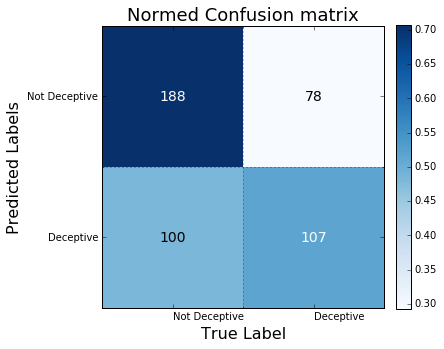

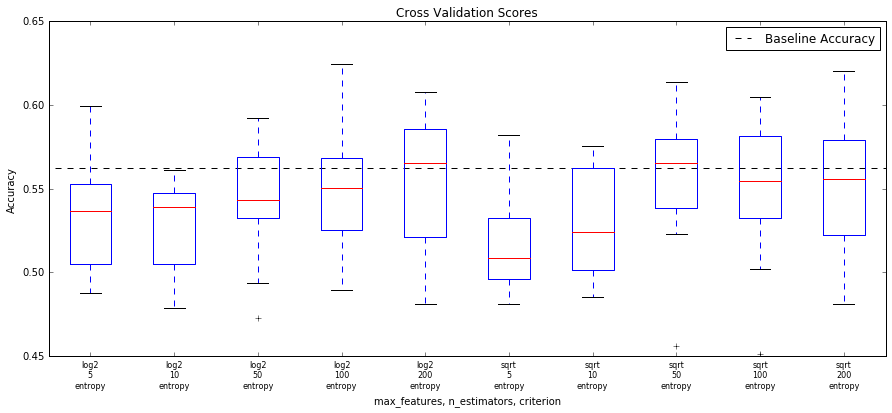

In [317]:
plot_confusion_matrix(rf_results['cm'])
plot_grid_scores(rf_results['grid_scores'])

## Logistic Regression: Ridge

In [321]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR(verbose=0, n_jobs=-1, random_state=random_seed)
param_grid = dict(
                  penalty=['l2'], 
#                   dual=False, 
#                   tol=0.0001, 
                  C=list(np.logspace(-8,3, 12)), 
#                   fit_intercept=True, 
#                   intercept_scaling=1, 
#                   class_weight=None, 
#                   random_state=None, 
#                   solver='liblinear', 
#                   max_iter=100, 
#                   multi_class='ovr', 
#                   verbose=0, 
#                   warm_start=False, 
#                   n_jobs=1
                 )
lr2_results = experiment(lr, param_grid)

Searching Grid...
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 16.7min finished


Fitting best estimator...
Chosen parameters: 
{'penalty': 'l2', 'C': 0.01}
Best Estimator: 
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Evaluating on Test...
Test Accuracy: 0.5032, Test F1: 0.4835 (P:0.44 R:0.53)


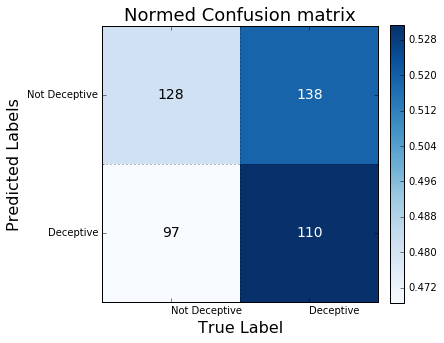

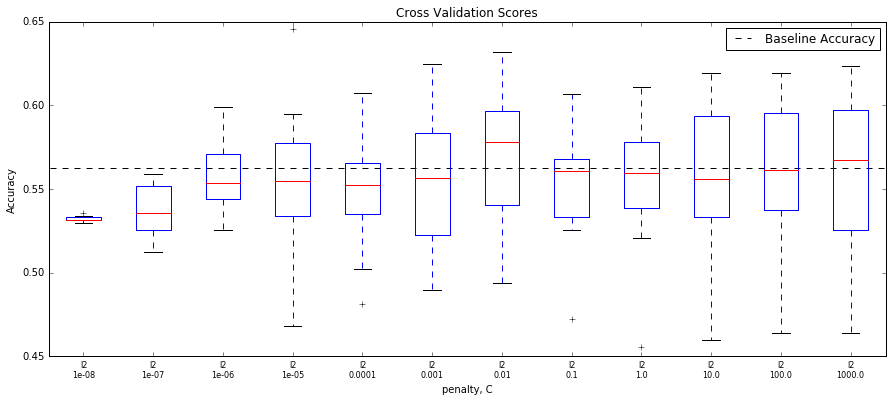

In [322]:
plot_confusion_matrix(lr2_results['cm'])
plot_grid_scores(lr2_results['grid_scores'])

## Logistic Regression: L1 Regulatrization

In [325]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR(verbose=0, n_jobs=-1, random_state=random_seed)
param_grid = dict(
                  penalty=['l1'], 
#                   dual=False, 
#                   tol=0.0001, 
                  C=list(np.logspace(-4,4, 12)), 
#                   fit_intercept=True, 
#                   intercept_scaling=1, 
#                   class_weight=None, 
#                   random_state=None, 
#                   solver='liblinear', 
#                   max_iter=100, 
#                   multi_class='ovr', 
#                   verbose=0, 
#                   warm_start=False, 
#                   n_jobs=1
                 )
lr1_results = experiment(lr, param_grid)

Searching Grid...
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  8.7min finished


Fitting best estimator...
Chosen parameters: 
{'penalty': 'l1', 'C': 65.79332246575683}
Best Estimator: 
LogisticRegression(C=65.79332246575683, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Evaluating on Test...
Test Accuracy: 0.4841, Test F1: 0.4719 (P:0.43 R:0.53)


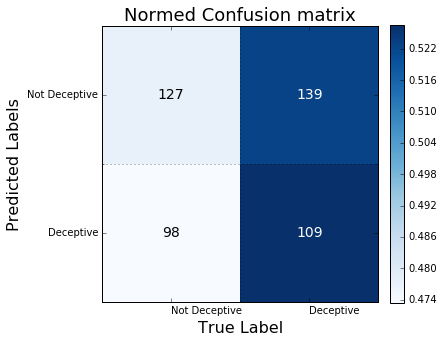

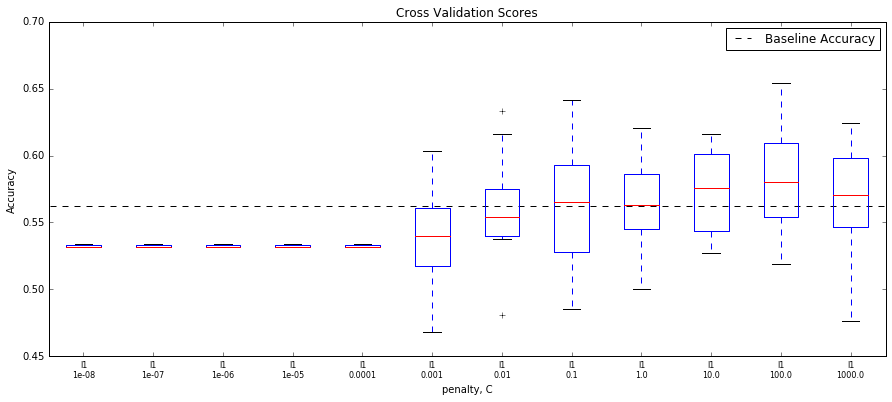

In [324]:
plot_confusion_matrix(lr1_results['cm'])
plot_grid_scores(lr1_results['grid_scores'])